In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import nltk

In [2]:
# Убедимся, что необходимые ресурсы загружены
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Загрузка данных
oil_price_path = 'BrentOilPrices.csv'
news_path = 'news.csv'

In [4]:
# Чтение данных
oil_data = pd.read_csv(oil_price_path)
news_data = pd.read_csv(news_path)

In [5]:
# Изменение названия колонки в BrentOilPrices
oil_data.rename(columns={'Data': 'date'}, inplace=True)

In [6]:
# Приведение колонок к нижнему регистру
oil_data.columns = oil_data.columns.str.lower()
news_data.columns = news_data.columns.str.lower()

In [7]:
# Преобразование даты в формат datetime
oil_data['date'] = pd.to_datetime(oil_data['date'], errors='coerce')
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24796\2511022803.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  oil_data['date'] = pd.to_datetime(oil_data['date'], errors='coerce')


In [8]:
# Удаление времени из столбца date в news_data и oil_data
news_data['date'] = news_data['date'].dt.date
oil_data['date'] = oil_data['date'].dt.date

In [9]:
# Удаление строк с некорректными датами
oil_data = oil_data.dropna(subset=['date']).sort_values('date')
news_data = news_data.dropna(subset=['date'])

In [10]:
# Нормализация цен на нефть
scaler = MinMaxScaler()
oil_data['price'] = scaler.fit_transform(oil_data[['price']])

In [11]:
# Анализ тональности текстов
sia = SentimentIntensityAnalyzer()
news_data['sentiment'] = news_data['text'].fillna("").apply(lambda x: sia.polarity_scores(x)['compound'])

In [12]:
# Проверка диапазона дат
oil_date_range = (oil_data['date'].min(), oil_data['date'].max())
news_date_range = (news_data['date'].min(), news_data['date'].max())
print(f"Oil data date range: {oil_date_range}")
print(f"News data date range: {news_date_range}")

Oil data date range: (datetime.date(1987, 5, 20), datetime.date(2022, 11, 14))
News data date range: (datetime.date(2018, 1, 4), datetime.date(2024, 3, 31))


In [13]:
# Ограничение данных общим диапазоном дат
common_start_date = max(oil_date_range[0], news_date_range[0])
common_end_date = min(oil_date_range[1], news_date_range[1])

oil_data_filtered = oil_data[(oil_data['date'] >= common_start_date) & (oil_data['date'] <= common_end_date)]
news_data_filtered = news_data[(news_data['date'] >= common_start_date) & (news_data['date'] <= common_end_date)]

In [14]:
# Объединение данных по дате
merged_data = pd.merge(oil_data_filtered, news_data_filtered, on='date', how='inner')

In [15]:
# Проверка итогового объединенного датасета
print(f"Rows in merged data: {len(merged_data)}")
print(merged_data.head())

Rows in merged data: 71128
         date     price                                               text  \
0  2018-01-04  0.442195  Farmers will get subsidies for turning fields ...   
1  2018-01-04  0.442195  Vanuatu bans non-biodegradable plastic to prot...   
2  2018-01-04  0.442195  Ex-British PM Tony Blair ups calls for Labour ...   
3  2018-01-04  0.442195  UK's Tony Blair argues voters deserve another ...   
4  2018-01-04  0.442195  Germany had so much renewable energy over Chri...   

     label  sentiment  
0  politic    -0.7783  
1  politic     0.2023  
2  politic     0.1531  
3  politic    -0.3818  
4  politic    -0.0609  


In [16]:
# Подготовка данных для LSTM
sequence_length = 30
step = 1

timeseries_data = merged_data['price'].values
sentiment_data = merged_data['sentiment'].values

X = []
Y = []
for i in range(0, len(timeseries_data) - sequence_length, step):
    sequence = np.column_stack((timeseries_data[i:i + sequence_length], sentiment_data[i:i + sequence_length]))
    X.append(sequence)
    Y.append(timeseries_data[i + sequence_length])

X = np.array(X)
Y = np.array(Y)

In [17]:
# Walk-Forward Validation
n_splits = 5
split_size = len(X) // n_splits

all_mae = []
for i in range(n_splits):
    # Определение обучающей и тестовой выборки для текущего фолда
    train_end = split_size * (i + 1)
    X_train, X_test = X[:train_end], X[train_end:]
    Y_train, Y_test = Y[:train_end], Y[train_end:]

    if len(X_test) == 0:
        break

    # Построение модели LSTM
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, 2)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=5,
        batch_size=32,
        verbose=0
    )

    # Оценка модели
    loss, mae = model.evaluate(X_test, Y_test, verbose=0)
    all_mae.append(mae)
    print(f"Fold {i + 1}: Mean Absolute Error = {mae}")

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1: Mean Absolute Error = 0.006799550727009773
Fold 2: Mean Absolute Error = 0.024383481591939926
Fold 3: Mean Absolute Error = 0.011259524151682854
Fold 4: Mean Absolute Error = 0.08027935028076172
Fold 5: Mean Absolute Error = 0.01282407809048891


In [18]:
# Средняя ошибка по всем фолдам
print(f"Average MAE across all folds: {np.mean(all_mae)}")

Average MAE across all folds: 0.027109196968376638


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


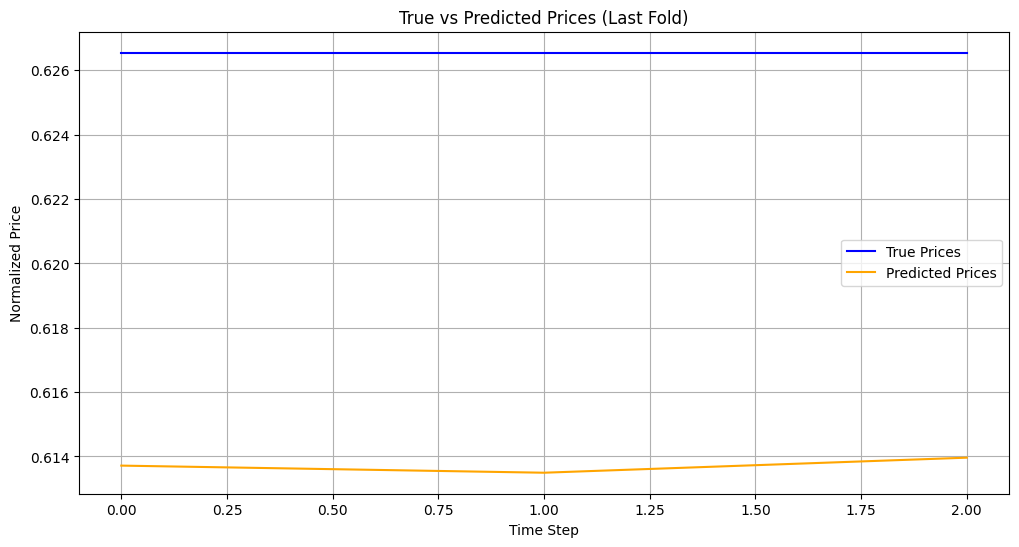

In [19]:
# Визуализация прогнозов последнего фолда
predicted_prices = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(Y_test, label='True Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange')
plt.title('True vs Predicted Prices (Last Fold)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid()
plt.show()